In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
import ForwardDiff
import Convex as cvx 
import ECOS
using LinearAlgebra
using Plots

  Activating environment at `~/devel/hw_ideas/hw4/Project.toml`


In [2]:
function double_integrator_AB(dt)::Tuple{Matrix,Matrix}
    Ac = [0 0 1 0;
          0 0 0 1;
          0 0 0 0;
          0 0 0 0.]
    Bc = [0 0;
          0 0;
          1 0;
          0 1]
    nx, nu = size(Bc)
        
    # TODO: discretize this linear system using the Matrix Exponential
    
    # matrix exponential 
    H = exp([Ac Bc; zeros(nu, nx + nu)]*dt)
    A = H[1:nx,1:nx]
    B = H[1:nx,(nx + 1):(nx + nu)]
    
    return A, B 
end

double_integrator_AB (generic function with 1 method)

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342


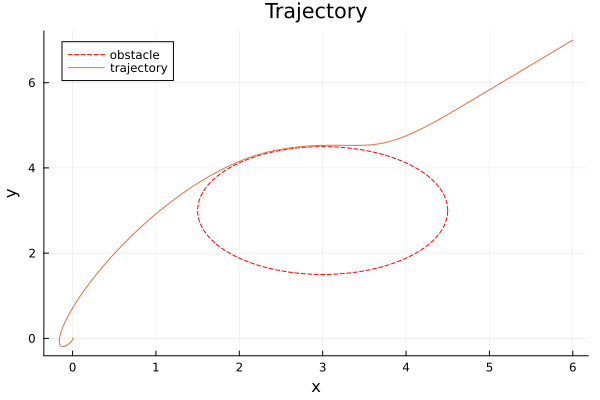

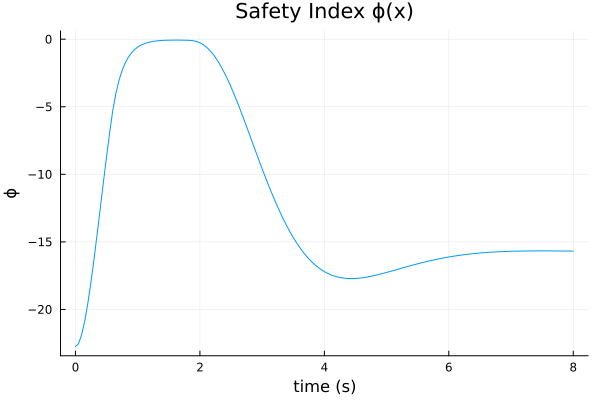

In [43]:
function ϕ(x)
    p = x[1:2]  
    -(norm(p - [3,3])^2 - 1.5^2) 
end
function ∇ϕ(x)
    ForwardDiff.gradient(ϕ, x)
end
function cbf(x::Vector,  # current state 
             u0::Vector, # nominal control input 
             A::Matrix,  # discrete time A 
             B::Matrix,  # discrete time B 
             dt::Real)   # time step size 
    
    # tune this (lower the number = more aggressive)
    λ = -5
    
    # our variable we are solving for 
    u = cvx.Variable(2)
    
    # let's approximate xdot with a difference between (x_{k+1} - x_k)/dt
    # this is because if we just did the continuous time dynamics, ϕdot would 
    # be zero. This is because if x = [p;v], dϕ/dx = [dϕ/dp; 0] since it only depends on 
    # the position, not velocity. our continous time dynamics are xdot = [v;u], meaning when
    # we take ∇ϕ'ẋ, we get [dϕ/dp; 0]'[v;u], which is not a function of u. This is because u
    # cannot directly affect ṗ. If instead we average xdot over a time step, u can now affect
    # ṗ, and everything works out. 
    xdot = ((A*x + B*u) - x)/dt
    ϕdot = ∇ϕ(x)'*xdot 

    # find the closest control to the given u0
    prob = cvx.minimize(cvx.sumsquares(u - u0))
    
    # must be safe
    prob.constraints += [ϕdot <= λ*ϕ(x)]
    
    cvx.solve!(prob, ECOS.Optimizer; silent_solver = true)
    
    return vec(u.value)
end
function circle()
    center = [3,3]
    rad = 1.5 
    θs = range(0,2*pi,length = 100)
    points = [(rad*[cos(θ),sin(θ)]+center) for θ in θs]
    x = [p[1] for p in points]
    y = [p[2] for p in points]
    x, y
end
    
let 
    
    # double integrator dynamics 
    dt = 0.05 
    A,B = double_integrator_AB(dt)
    tf = 8.0 
    t_vec = 0:dt:tf 
    N = length(t_vec)
    X = [zeros(4) for i = 1:N]
    X[1] = [6,7,0,0]
    
    # simple PD controller
    kp = 2.0; kd = 2.0 
    K = [kp*I(2)  kd*I(2)]
    
    # sim 
    for i = 1:(N-1)
        u0 = -K*X[i]            # nominal control 
        u = cbf(X[i],u0,A,B,dt) # modified safe control 
        X[i+1] = A*X[i] + B*u 
    end
    
    Xm = hcat(X...)
    
    x, y = circle()
    plot(x,y,lc = :red, ls = :dash,label = "obstacle")
    display(plot!(Xm[1,:],Xm[2,:], label  = "trajectory", xlabel = "x", ylabel = "y", title = "Trajectory"))
    
    ϕs = ϕ.(X)
    plot(t_vec,ϕs,label = "",xlabel = "time (s)", ylabel = "ϕ", title = "Safety Index ϕ(x)")
    
end